# Terrain Classification - All Data
### Created by Keenan McConkey 2019.08.01

Imports all the types of preprocessed feature vectors from all users, runs feature selection and trains/compares classifiers on the feature vectors, and exports the best classifiers using joblib

In [1]:
from __future__ import absolute_import, division, print_function

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pymrmr
import sklearn

## Part 1 - Importing Preprocessed Data

### Part (a) - Functions for Data Import

In [2]:
# All the terrains, placements, vectors, power-assistance, users in the study
terrains = ['Concrete', 'Carpet', 'Linoleum', 'Asphalt', 'Sidewalk', 'Grass', 'Gravel']
powers = ['Manual'] # TODO: Fix power PSD data and add back in
placements_manual = ['Middle', 'Left', 'Right', 'Synthesis']
placements_power = ['Middle']
vectors = ['TimeFeats', 'FreqFeats', 'FFTs', 'PSDLogs']
users = ['All'] # TODO: Go back to split users
axes = ['X Accel', 'Y Accel', 'Z Accel', 'X Gyro', 'Y Gyro', 'Z Gyro']
CURR_PATH = os.path.dirname(os.path.realpath('__file__')) # Relative path of this notebook

In [3]:
'''Get the integer terrain value of a given label'''
def get_terrain_num(_label):
    for i, terrain in enumerate(terrains):
        if terrain in _label:
            return i
        
    raise Exception('Unknown terrain')

'''Get the name associated with a terrain integer'''
def get_terrain_name(terrain_num):
    return terrains[terrain_num]
    return terrains[terrain_num]

'''Get the placement location name for given label'''
def get_placement(_label):
    for placement in placements:
        if placement in _label:
            return placement
    
    raise Exception('Unknown placement')

'''Get the transform used for given label'''
def get_transform(_label):
    for transform in transforms:
        if transform in _label:
            return transform
    
    raise Exception('Unknown transform')

### Part (b) - Import Processed Data from Each User

In [4]:
'''Combine data from labelled datasets into a single dataframe'''
def combine_datasets(datasets):
    return pd.concat(list(datasets.values()), ignore_index=True, sort=False)

In [5]:
data_path = os.path.join(CURR_PATH, 'processed_data', 'new_setup', 'new_normalization')

# Nested dictionary of processed data:
# - Power assistance type
# -- Placement
# --- Feature Vector
# ---- User
power_dict = {}

# Create each nesting of the dictionary
for power in powers:
    placement_dict = {}
    
    # Power datasets only have middle placement (for now)
    if power == 'Power':
        placements = placements_power.copy()
    else:
        placements = placements_manual.copy()
    
    for placement in placements:
        vector_dict = {}

        for vector in vectors:
            user_dict = {}

            for user in users:
                # File name based on above parameters
                filename = placement + '_' + vector + '_' + user 
                if power == 'Power':
                    filename += '_Power'
                filename += '.csv'
                os.path.join(data_path, power.lower, filename)
                
                # Read data and update current user dictionary
                data = pd.read_csv(path + filename)
                user_dict.update({user: data})

            # Combine users to form a new entry of user dictionary, save to .csv
            # NaNs arise when you combine Synthesis feature vectors
            # Commented out because we don't seem to need it here
            #combined_data = combine_datasets(user_dict).dropna(axis='columns')
            #user_dict.update({'All': combined_data})

            vector_dict.update({vector: user_dict})
        
        # Create a dictionary of the combined feature vectors for each user
        combined_vector_user_dict = {}
        combined_extracted_vector_user_dict = {}
        
        for user in user_dict.keys():
            # Get extraced vector/all vectors for current user and pop label column
            user_extracted_vectors = []
            user_all_vectors = []
            
            # Extracted vectors only
            for extracted_vector in ['TimeFeats', 'FreqFeats']:
                user_vector = vector_dict[extracted_vector][user]
                # Get append everything not label column since this is the same for all vectors
                labels = user_vector['Label']
                user_extracted_vectors.append(user_vector.loc[:, user_vector.columns != 'Label'])
            
            # Add the extracted vectors to the fully combined vector
            user_all_vectors.extend(user_extracted_vectors)
            
            # Add in the transform vectors
            for transform_vector in ['FFTs', 'PSDLogs']:
                user_vector = vector_dict[transform_vector][user]
                # Get append everything not label column since this is the same for all vectors
                labels = user_vector['Label']
                user_all_vectors.append(user_vector.loc[:, user_vector.columns != 'Label'])
            
            # Combine extracted vectors and add back label column
            combined_extracted_vector = pd.concat(user_extracted_vectors, axis='columns')
            combined_extracted_vector.insert(loc=0, column='Label', value=labels)
            combined_extracted_vector_user_dict.update({user: combined_extracted_vector})
            
            # Combine vectors and add back label column
            combined_vector = pd.concat(user_all_vectors, axis='columns')
            combined_vector.insert(loc=0, column='Label', value=labels)
            combined_vector_user_dict.update({user: combined_vector})
        
        # Add the combined feature vector to the vector dictionary
        vector_dict.update({'AllFeats': combined_extracted_vector_user_dict})
        vector_dict.update({'Combined': combined_vector_user_dict})
        
        placement_dict.update({placement: vector_dict})
    
    power_dict.update({power: placement_dict})

In [6]:
# Update vectors to reflect new combined vectors
vectors.extend(['AllFeats', 'Combined'])

In [7]:
# Check some data
power_dict['Manual']['Middle']['AllFeats']['All'].tail()

,Label,Mean X Accel Middle,Std X Accel Middle,Norm X Accel Middle,AC X Accel Middle,Max X Accel Middle,Min X Accel Middle,RMS X Accel Middle,ZCR X Accel Middle,Skew X Accel Middle,...,MSF Y Gyro Middle,RMSF Y Gyro Middle,FC Y Gyro Middle,VF Y Gyro Middle,RVF Y Gyro Middle,MSF Z Gyro Middle,RMSF Z Gyro Middle,FC Z Gyro Middle,VF Z Gyro Middle,RVF Z Gyro Middle
16065,4,-2.993490,0.058487,0.409874,0.094989,-0.334863,-0.373391,0.409337,0.086221,0.142740,...,0.201499,0.868215,1.188687,-1.518781,0.868215,0.617916,0.930225,-0.285041,0.168249,0.930225
16066,4,-5.150751,-0.420820,0.824175,0.433643,-0.860113,-0.373391,0.823611,-1.417281,-0.250344,...,-0.071406,0.332945,1.279011,-1.683046,0.332945,6.661553,4.234812,-0.091530,0.137974,4.234812
16067,4,-2.704405,-0.045126,0.249784,-0.019371,-0.793978,-0.047606,0.249256,-0.414946,-0.222345,...,-0.276171,-0.438779,0.745796,-0.775163,-0.438779,-0.055719,0.219836,-0.403381,0.182817,0.219836
16068,4,2.020397,-0.459843,-0.191738,-0.287109,-0.497873,0.697808,-0.192238,-0.359261,-0.638358,...,-0.267376,-0.372804,0.803745,-0.866864,-0.372804,1.136647,1.362874,-0.324626,0.173604,1.362874
16069,4,2.414125,0.033483,0.312220,0.024136,-0.173717,0.378144,0.311688,-0.971799,-0.985338,...,-0.276833,-0.444297,0.375796,-0.229739,-0.444297,1.937146,1.927521,-0.041820,0.127822,1.927521


In [8]:
# Check some data
power_dict['Manual']['Synthesis']['Combined']['All'].tail()

,Label,Mean Calc X Vel Synthesis,Std Calc X Vel Synthesis,Norm Calc X Vel Synthesis,AC Calc X Vel Synthesis,Max Calc X Vel Synthesis,Min Calc X Vel Synthesis,RMS Calc X Vel Synthesis,ZCR Calc X Vel Synthesis,Skew Calc X Vel Synthesis,...,PSDLog 54 Hz Right Z Gyro Synthesis,PSDLog 55 Hz Right Z Gyro Synthesis,PSDLog 56 Hz Right Z Gyro Synthesis,PSDLog 57 Hz Right Z Gyro Synthesis,PSDLog 58 Hz Right Z Gyro Synthesis,PSDLog 59 Hz Right Z Gyro Synthesis,PSDLog 60 Hz Right Z Gyro Synthesis,PSDLog 61 Hz Right Z Gyro Synthesis,PSDLog 62 Hz Right Z Gyro Synthesis,PSDLog 63 Hz Right Z Gyro Synthesis
17889,4,-0.793959,1.065550,-0.775904,-0.722220,-0.172572,-0.817171,-0.777825,-0.153511,1.123875,...,1.466184,1.508826,1.498868,1.499795,1.487310,1.457920,1.448934,1.489991,1.482408,1.457884
17890,4,0.033568,1.112526,0.049535,-0.137233,0.166666,-0.425848,0.048307,-0.153511,-0.798948,...,1.578223,1.563516,1.572959,1.573727,1.574875,1.576434,1.569256,1.565444,1.565786,1.560195
17891,4,-0.105755,2.305017,-0.031710,-0.205648,0.166666,-1.095395,-0.033006,-0.153511,-1.220858,...,-0.002977,0.003201,-0.023648,0.028786,0.044417,0.046217,0.042515,0.054399,0.038207,0.077722
17892,4,-1.251162,2.456792,-1.083621,-0.877803,-0.182611,-1.430997,-1.082005,-0.153511,1.513885,...,-0.661928,-0.652665,-0.628604,-0.644654,-0.625274,-0.576349,-0.573515,-0.598476,-0.600726,-0.544136
17893,4,-1.848859,-1.202419,-2.054550,-1.146205,-2.072623,-1.430997,-1.937256,-0.153511,2.309932,...,-1.161979,-1.159322,-1.131727,-1.110872,-1.096042,-1.076248,-1.073040,-1.049085,-1.042129,-1.024189


## Part 2 -  mRMR (minimum Redunancy Maximum Relevance)

mRMR tries to find which features have the highest information shared with classified state and lowest information shared with other features.

### Part (a) - Middle Frame Placement

#### Part (i) - Manual Wheelchair

In [90]:
pymrmr.mRMR(data=power_dict['Manual']['Middle']['TimeFeats']['All'], method='MID', nfeats=5)

['ZCR Y Gyro Middle',
 'ZCR Y Accel Middle',
 'ZCR Z Accel Middle',
 'ZCR X Accel Middle',
 'Std Y Accel Middle']

In [10]:
pymrmr.mRMR(data=power_dict['Manual']['Middle']['FreqFeats']['All'], method='MID', nfeats=5)

['FC Y Gyro Middle',
 'FC Y Accel Middle',
 'VF Z Accel Middle',
 'FC X Gyro Middle',
 'VF Y Gyro Middle']

In [11]:
pymrmr.mRMR(data=power_dict['Manual']['Middle']['AllFeats']['All'], method='MID', nfeats=5)

['FC Y Gyro Middle',
 'ZCR Y Accel Middle',
 'ZCR Z Accel Middle',
 'VF X Gyro Middle',
 'VF Y Gyro Middle']

In [12]:
pymrmr.mRMR(data=power_dict['Manual']['Middle']['FFTs']['All'], method='MID', nfeats=5)

['FFT 14 Hz Y Accel Middle',
 'FFT 1 Hz Y Gyro Middle',
 'FFT 2 Hz X Gyro Middle',
 'FFT 17 Hz Z Accel Middle',
 'FFT 21 Hz Y Accel Middle']

In [13]:
pymrmr.mRMR(data=power_dict['Manual']['Middle']['PSDLogs']['All'], method='MID', nfeats=5)

['PSDLog 33 Hz Y Gyro Middle',
 'PSDLog 0 Hz Y Gyro Middle',
 'PSDLog 56 Hz Y Accel Middle',
 'PSDLog 1 Hz X Gyro Middle',
 'PSDLog 59 Hz Y Accel Middle']

In [14]:
pymrmr.mRMR(data=power_dict['Manual']['Middle']['Combined']['All'], method='MID', nfeats=5)

['FC Y Gyro Middle',
 'PSDLog 12 Hz Z Accel Middle',
 'VF X Gyro Middle',
 'ZCR Z Accel Middle',
 'ZCR Y Accel Middle']

#### Part (i) - Power Assist Wheelchair

In [15]:
#pymrmr.mRMR(data=power_dict['Power']['Middle']['Features']['All'], method='MID', nfeats=5)

In [16]:
#pymrmr.mRMR(data=power_dict['Power']['Middle']['FFTs']['All'], method='MID', nfeats=5)

In [17]:
#pymrmr.mRMR(data=power_dict['Power']['Middle']['PSDLogs']['All'], method='MID', nfeats=5)

In [18]:
#pymrmr.mRMR(data=power_dict['Power']['Middle']['Combined']['All'], method='MID', nfeats=5)

### Part (b) - Left Wheel Placement

In [19]:
pymrmr.mRMR(data=power_dict['Manual']['Left']['TimeFeats']['All'], method='MID', nfeats=5)

['Std Z Accel Left',
 'ZCR Z Accel Left',
 'Min Z Gyro Left',
 'ZCR Y Accel Left',
 'ZCR Y Gyro Left']

In [20]:
pymrmr.mRMR(data=power_dict['Manual']['Left']['FreqFeats']['All'], method='MID', nfeats=5)

['FC Z Accel Left',
 'RVF Y Accel Left',
 'FC X Accel Left',
 'FC Y Accel Left',
 'RVF Z Accel Left']

In [21]:
pymrmr.mRMR(data=power_dict['Manual']['Left']['AllFeats']['All'], method='MID', nfeats=5)

['Std Z Accel Left',
 'FC Z Accel Left',
 'ZCR Y Gyro Left',
 'ZCR Z Accel Left',
 'Min Z Gyro Left']

In [22]:
pymrmr.mRMR(data=power_dict['Manual']['Left']['FFTs']['All'], method='MID', nfeats=5)

['FFT 20 Hz Z Accel Left',
 'FFT 43 Hz Z Accel Left',
 'FFT 14 Hz Z Accel Left',
 'FFT 63 Hz Z Accel Left',
 'FFT 38 Hz Z Accel Left']

In [23]:
pymrmr.mRMR(data=power_dict['Manual']['Left']['PSDLogs']['All'], method='MID', nfeats=5)

['PSDLog 27 Hz Z Accel Left',
 'PSDLog 62 Hz Z Accel Left',
 'PSDLog 17 Hz Z Accel Left',
 'PSDLog 40 Hz Z Accel Left',
 'PSDLog 48 Hz X Accel Left']

In [24]:
pymrmr.mRMR(data=power_dict['Manual']['Left']['Combined']['All'], method='MID', nfeats=5)

['PSDLog 27 Hz Z Accel Left',
 'FC Z Accel Left',
 'PSDLog 17 Hz Z Accel Left',
 'PSDLog 63 Hz Z Accel Left',
 'PSDLog 48 Hz X Accel Left']

### Part (c) - Right Wheel Placement

In [25]:
pymrmr.mRMR(data=power_dict['Manual']['Right']['TimeFeats']['All'], method='MID', nfeats=5)

['ZCR Z Accel Right',
 'RMS Z Accel Right',
 'Max Z Gyro Right',
 'ZCR Y Gyro Right',
 'Max Z Accel Right']

In [26]:
pymrmr.mRMR(data=power_dict['Manual']['Right']['FreqFeats']['All'], method='MID', nfeats=5)

['VF Z Accel Right',
 'RVF X Accel Right',
 'FC Y Accel Right',
 'RVF Z Accel Right',
 'FC X Accel Right']

In [27]:
pymrmr.mRMR(data=power_dict['Manual']['Right']['AllFeats']['All'], method='MID', nfeats=5)

['ZCR Z Accel Right',
 'RMS Z Accel Right',
 'VF Z Accel Right',
 'Max Z Gyro Right',
 'FC X Accel Right']

In [28]:
pymrmr.mRMR(data=power_dict['Manual']['Right']['FFTs']['All'], method='MID', nfeats=5)

['FFT 24 Hz Z Accel Right',
 'FFT 63 Hz Z Accel Right',
 'FFT 18 Hz Z Accel Right',
 'FFT 14 Hz Z Accel Right',
 'FFT 53 Hz Z Accel Right']

In [29]:
pymrmr.mRMR(data=power_dict['Manual']['Right']['PSDLogs']['All'], method='MID', nfeats=5)

['PSDLog 62 Hz Z Accel Right',
 'PSDLog 15 Hz Z Accel Right',
 'PSDLog 55 Hz Z Accel Right',
 'PSDLog 25 Hz Z Accel Right',
 'PSDLog 63 Hz Z Accel Right']

In [30]:
pymrmr.mRMR(data=power_dict['Manual']['Right']['Combined']['All'], method='MID', nfeats=5)

['ZCR Z Accel Right',
 'PSDLog 16 Hz Z Accel Right',
 'VF Z Accel Right',
 'PSDLog 26 Hz Z Accel Right',
 'PSDLog 62 Hz Z Accel Right']

### Part (d) - Synthesis "Placement"

In [31]:
pymrmr.mRMR(data=power_dict['Manual']['Synthesis']['TimeFeats']['All'], method='MID', nfeats=5)

['ZCR Right Z Accel Synthesis',
 'Min Left XY Accel Synthesis',
 'Min Calc X Vel Synthesis',
 'Min Right XY Accel Synthesis',
 'RMS Right Z Accel Synthesis']

In [32]:
pymrmr.mRMR(data=power_dict['Manual']['Synthesis']['FreqFeats']['All'], method='MID', nfeats=5)

['VF Left XY Accel Synthesis',
 'RMSF Left XY Accel Synthesis',
 'VF Right Z Accel Synthesis',
 'FC Right XY Accel Synthesis',
 'FC Left Z Accel Synthesis']

In [33]:
pymrmr.mRMR(data=power_dict['Manual']['Synthesis']['AllFeats']['All'], method='MID', nfeats=5)

['VF Left XY Accel Synthesis',
 'Min Left XY Accel Synthesis',
 'ZCR Right Z Accel Synthesis',
 'FC Right XY Accel Synthesis',
 'VF Right Z Accel Synthesis']

In [34]:
pymrmr.mRMR(data=power_dict['Manual']['Synthesis']['FFTs']['All'], method='MID', nfeats=5)

['FFT 25 Hz Left XY Accel Synthesis',
 'FFT 0 Hz Calc X Vel Synthesis',
 'FFT 17 Hz Right Z Accel Synthesis',
 'FFT 28 Hz Right XY Accel Synthesis',
 'FFT 58 Hz Left XY Accel Synthesis']

In [35]:
pymrmr.mRMR(data=power_dict['Manual']['Synthesis']['PSDLogs']['All'], method='MID', nfeats=5)

['PSDLog 35 Hz Left XY Accel Synthesis',
 'PSDLog 16 Hz Right Z Accel Synthesis',
 'PSDLog 49 Hz Right XY Accel Synthesis',
 'PSDLog 50 Hz Left XY Accel Synthesis',
 'PSDLog 18 Hz Left XY Accel Synthesis']

In [36]:
pymrmr.mRMR(data=power_dict['Manual']['Synthesis']['Combined']['All'], method='MID', nfeats=5)

['VF Left XY Accel Synthesis',
 'Min Left XY Accel Synthesis',
 'ZCR Right Z Accel Synthesis',
 'FC Right XY Accel Synthesis',
 'VF Right Z Accel Synthesis']

### Part (e) - Nested Dictionary of Top Features

In [37]:
# Create dictionary of top mRMR features to speed up calculations, up to to 50
power_dict_features = {}

'''
for power in powers:
    placement_dict_features = {}
    
    for placement in placements:
        vector_dict_features = {}
        
        for vector in vectors:
            user_dict_features = {}

            # Only calculate for all users for now
            for user in ['All']:
                top_features = pymrmr.mRMR(data=power_dict[power][placement][vector][user],
                                           method='MID', nfeats=50)
                user_dict_features.update({user: top_features})

            vector_dict_features.update({vector: user_dict_features})
            
        placement_dict_features.update({placement: vector_dict_features})
    
    power_dict_features.update({power: placement_dict_features})
'''

In [64]:
# Pickle the dictionary
import joblib

mRMR_dict_filename = os.path.join(CURR_PATH, 'dicts', 'mRMR_Top50_Dictionary.joblib')
joblib.dump(power_dict_features, mRMR_dict_filename)

['/home/caris/Wheelchair-Terrain-Classification/dicts/mRMR_Top50_Dictionary.joblib']

In [67]:
# Load the dictionary from joblib
power_dict_test = joblib.load(mRMR_dict_filename)

## Part 3 - PCA (Principal Component Analysis)

In [40]:
#TODO: Test mRMR into PCA
# Normalize after PCA again?

from sklearn.decomposition import PCA

'''Get the principal component form of a DataFrame, for given number of PC'''
def get_pca_df(combined_data, n_components=2):
    # Setup PCA parameters
    pca = PCA(n_components=n_components)
    
    # Copy data to avoid modification
    data = combined_data.copy()
    
    # Extract terrain labels
    labels = data.pop('Label')
    
    # Get specified number of principal components and convert to dataframe
    pc = pca.fit_transform(data)
    pc_df = pd.DataFrame(data=pc, columns=['PC {}'.format(i + 1) for i in range(n_components)])
    
    #print('Explained Variance of Each PC: {}'.format(pca.explained_variance_ratio_))
    #print('Total Explained Variance: {}'.format(np.sum(pca.explained_variance_ratio_)))
    
    return pd.concat([labels, pc_df], axis='columns')

In [41]:
get_pca_df(power_dict['Manual']['Synthesis']['Combined']['All']).tail()

,Label,PC 1,PC 2
17889,4,5.792989,24.492732
17890,4,-8.153356,21.772654
17891,4,-27.871236,34.857812
17892,4,-43.052504,31.491670
17893,4,-94.685398,-8.968278


In [42]:
get_pca_df(power_dict['Manual']['Synthesis']['Combined']['All'], n_components=5).tail()

,Label,PC 1,PC 2,PC 3,PC 4,PC 5
17889,4,5.792989,24.492732,8.702656,-4.225499,17.648474
17890,4,-8.153356,21.772654,-0.230455,-0.753911,28.570913
17891,4,-27.871236,34.857812,-23.323472,-1.885680,-8.960346
17892,4,-43.052504,31.491669,-28.983240,-2.599883,-10.584888
17893,4,-94.685398,-8.968280,-51.817433,-99.844279,5.259681


In [43]:
'''Plot a 2D Principal Component DataFrame'''
def visualize_2d_pca(pca_2d_df, figsize=(8, 8)):
    # Plot parameters
    plt.clf()
    plt.figure(figsize=figsize)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    
    # Scatter plot of each terrain
    for terrain in terrains:
        terrain_indices = pca_2d_df['Label'] == get_terrain_num(terrain)
        plt.scatter(pca_2d_df.loc[terrain_indices, 'PC 1'], pca_2d_df.loc[terrain_indices, 'PC 2'])
    
    plt.legend(terrains)
    plt.show()

<Figure size 432x288 with 0 Axes>

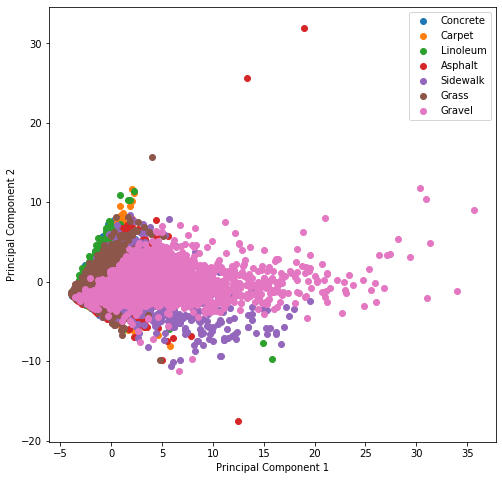

In [44]:
visualize_2d_pca(get_pca_df(power_dict['Manual']['Right']['FreqFeats']['All']))

## Part 4 - Comparing Classifier Accuracy

In [45]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Dictionary of classifiers
classifiers = {'Naive Bayes': GaussianNB(),
               'k Nearest': KNeighborsClassifier(),
               'Decision Tree': DecisionTreeClassifier(), 
               'Random Forest': RandomForestClassifier(n_estimators=100),
               'AdaBoost': AdaBoostClassifier(),
               'Support Vector Machine': SVC(gamma='scale')}

In [46]:
# TODO: Keep a part of the data separate for only training

from sklearn.model_selection import KFold

'''Run train test k-fold times
   Returns an tuple of arrays, where arrays elements are actual/predicted labels 
   for each k-fold test'''
def train_test_k_fold(combined_data, n_splits, model):
    # Shuffle ensures we get a mix of terrains
    kf = KFold(n_splits=n_splits, shuffle=True)

    # Copy data to avoid modification - Testing removing this
    data = combined_data
    
    # Extract terrain labels
    labels = data.pop('Label')

    # Array of predicted labels for each k fold
    test_k_fold = []
    predict_k_fold = []

    # Split into n splits
    for train_index, test_index in kf.split(data):
        train, test = data.loc[train_index], data.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
        
        # Actual labels
        test_k_fold.append(test_labels)
        
        # Train and test model
        model.fit(train, train_labels)
        predict_k_fold.append(model.predict(test))
    
    # Put back terrain labels
    data.insert(0, 'Label', labels)
    
    return (test_k_fold, predict_k_fold)

In [47]:
'''Train a model on all the given test data and return it'''
def train_model_on_all(combined_data, model):
    # Copy data to avoid modification - Testing removing this
    data = combined_data
    labels = data.pop('Label')
    
    # Train the model
    model.fit(data, labels)
    
    # Return the labels to original position
    data.insert(0, 'Label', labels)
    
    # Return trained model
    return model

In [48]:
'''Create a table of accuracies and associated trained models for each feature vector and classifier'''
def create_accuracy_table(n_splits, power_type='Manual', user_name='All', separate_axes=False,
                          feat_selection='None', n_feats=None, verbose=False):
    
    # Power type affects which placements are available
    if power_type == 'Manual':
        placements = placements_manual
    else:
        placements = placements_power
    
    # Dataframe table of accuracies for each classifier for each placement
    if separate_axes:
        vector_indices = [p + ' ' + v + ' ' + a for p in placements for v in vectors for a in axes]
    else:
        vector_indices = [p + ' ' + v for p in placements for v in vectors]
    
    # Vector column contains each vector for each placement and axes
    accuracy_table = pd.DataFrame({'Vector': vector_indices})
    
    # Nested dictionary of trained models:
    ## Vector type
    ### Classifier name
    model_dict = {vector_index: {} for vector_index in vector_indices}

    # Calculate accuracy for each placement for each feature vector and classifier
    for classifier_name, classifier in classifiers.items():
        model = classifier

        # Row dictionary for given model
        accuracy_rows = {}
        
        # Add current classifier to row dictionary
        for placement in placements:
            for vector in vectors:
                # Extract data for above parameters
                data = power_dict[power_type][placement][vector][user_name].copy()
                
                # Iterate through axes if we want them separate, else just put in empty string
                if separate_axes:
                    itr_axes = axes
                else:
                    itr_axes = ['All']
                
                for axis in itr_axes:
                    index_name = placement + ' ' + vector
                    data_temp = data
                    
                    # If separate axes, get data with only columns matching current axes
                    if separate_axes:
                        index_name += ' ' + axis
                        matching_columns = [column for column in data.columns if axis in column]
                        matching_columns.insert(0, 'Label')
                        data_temp = data_temp[matching_columns]
                    
                    # Use only the top features using mRMR feature selection
                    # TODO: Use only mRMR features from current axes
                    if feat_selection == 'mRMR':
                        top_feats = power_dict_features[power_type][placement][vector][user_name].copy()
                        top_feats.insert(0, 'Label')
                        data_temp = data_temp[top_feats[:n_feats+1]]

                    # Run PCA on the data
                    elif feat_selection == 'PCA':
                        data_temp = get_pca_df(data_temp, n_components=n_feats)

                    # Extract predicted and actual labels for requested user
                    actual, predict = train_test_k_fold(data_temp, n_splits, model)

                    # Take mean accuracy of k fold testing
                    accuracies = []
                    for i in range(len(predict)):
                        accuracies.append(accuracy_score(actual[i], predict[i]))
                    
                    # Update row dictionary
                    accuracy_rows.update({index_name: np.mean(accuracies)})
                    
                    # Train model on entire feature vector data and return it for pickling
                    trained_model = train_model_on_all(data_temp, model)
                    model_dict[index_name].update({classifier_name: trained_model})
                    
                    if verbose:
                        print('Finished training {} on {} {}'.format(classifier_name, placement, vector))
                    
        # Update accuracy table with classifier column by mapping row names to indices
        accuracy_table[classifier_name] = accuracy_table['Vector'].map(accuracy_rows)
    
    return accuracy_table, model_dict

In [ ]:
import joblib
models_path = os.path_join(CURR_PATH, 'models')

'''Export all the elements of a model dict to individual joblib files'''
def export_all_models(model_dict, file_tag=None):
    for feature_type, classifiers in model_dict.items():
        for classifier_name, trained_model in classifiers.items():
            # Get file name from parameters
            model_filename = classifier_name.replace(' ', '')
            model_filename += '_' + feature_type.replace(' ', '_')
            
            # Add file tag if given
            if file_tag is not None:
                model_filename += '_' + file_tag
            model_filename += '.joblib'
            model_filename = os.path.join(models_path, model_filename)
            
            # Pickle the file
            joblib.dump(trained_model, model_filename)

### Part (a) - Combined Axes Accuracy Table
#### Part (i) - No Feature Selection

In [50]:
# Create accuracy table for 5 k-fold splits without any feature selection
accuracy_table, model_dict = create_accuracy_table(n_splits=5, power_type='Manual', user_name='All')

In [51]:
accuracy_table

,Vector,Naive Bayes,k Nearest,Decision Tree,Random Forest,AdaBoost,Support Vector Machine
0,Middle TimeFeats,0.564655,0.841319,0.781269,0.896391,0.544119,0.883945
1,Middle FreqFeats,0.511388,0.684443,0.646173,0.744804,0.538270,0.698258
2,Middle FFTs,0.516241,0.723895,0.615308,0.783136,0.549160,0.822775
3,Middle PSDLogs,0.552209,0.739826,0.593964,0.745675,0.537150,0.811761
4,Middle AllFeats,0.577722,0.853018,0.794213,0.901618,0.593030,0.894400
5,Middle Combined,0.557312,0.829434,0.760485,0.875482,0.590853,0.910703
6,Left TimeFeats,0.482223,0.603750,0.620556,0.764777,0.542243,0.743569
7,Left FreqFeats,0.340173,0.511262,0.504001,0.624271,0.473304,0.571454
8,Left FFTs,0.461015,0.453699,0.510747,0.682348,0.518292,0.729164
9,Left PSDLogs,0.456614,0.506517,0.469589,0.663998,0.503944,0.722648


In [52]:
accuracy_table.to_csv(os.path.join(CURR_PATH, 'tables', 'Accuracy_Table.csv'), index=False)

In [ ]:
# Pickle all the models
export_all_models(model_dict)

In [62]:
# Try loading pickled model
test_model = joblib.load(os.path.joing(models_path, 'RandomForest_Middle_TimeFeats.joblib'))

test_model.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

#### Part (ii) - mRMR Feature Selection

In [71]:
# Create accuracy table for 5 k-fold splits with mRMR feature selection
accuracy_table_mRMR, model_dict_mRMR = create_accuracy_table(n_splits=5, 
                                                             power_type='Manual', user_name='All',
                                                             feat_selection='mRMR', n_feats=30)

In [73]:
accuracy_table_mRMR

,Vector,Naive Bayes,k Nearest,Decision Tree,Random Forest,AdaBoost,Support Vector Machine
0,Middle TimeFeats,0.651338,0.853454,0.770815,0.883074,0.544493,0.857312
1,Middle FreqFeats,0.514126,0.684941,0.639577,0.746111,0.538706,0.698942
2,Middle FFTs,0.540510,0.612819,0.553018,0.675607,0.549284,0.669135
3,Middle PSDLogs,0.570131,0.639639,0.566210,0.691164,0.539203,0.691226
4,Middle AllFeats,0.636839,0.811512,0.734848,0.838706,0.500062,0.802738
5,Middle Combined,0.622651,0.725576,0.645240,0.762539,0.472558,0.752022
6,Left TimeFeats,0.483595,0.640792,0.625643,0.765920,0.538014,0.734538
7,Left FreqFeats,0.342004,0.511490,0.502801,0.629301,0.469761,0.572710
8,Left FFTs,0.450841,0.462787,0.386132,0.530867,0.450097,0.535040
9,Left PSDLogs,0.454785,0.451127,0.402367,0.542015,0.448382,0.546359


In [56]:
accuracy_table_mRMR.to_csv(os.path.join(CURR_PATH, 'tables', 'Accuracy_Table_mRMR.csv'), index=False)

#### Part (iii) - PCA Feature Selection

In [57]:
# Create accuracy table for 5 k-fold splits with mRMR feature selection
accuracy_table_PCA, model_dict_PCA = create_accuracy_table(n_splits=5, 
                                                           power_type='Manual', user_name='All',
                                                           feat_selection='PCA', n_feats=20)

In [58]:
accuracy_table_PCA

,Vector,Naive Bayes,k Nearest,Decision Tree,Random Forest,AdaBoost,Support Vector Machine
0,Middle TimeFeats,0.646297,0.819851,0.690915,0.824020,0.563410,0.850902
1,Middle FreqFeats,0.546173,0.685190,0.618419,0.726945,0.539079,0.699378
2,Middle FFTs,0.516428,0.781207,0.666335,0.804605,0.540884,0.769011
3,Middle PSDLogs,0.715806,0.787057,0.670255,0.791724,0.598507,0.794088
4,Middle AllFeats,0.659179,0.824642,0.716304,0.831363,0.522215,0.849596
5,Middle Combined,0.653951,0.812819,0.708276,0.826633,0.560983,0.821344
6,Left TimeFeats,0.450841,0.580142,0.531497,0.665085,0.457071,0.696696
7,Left FreqFeats,0.347262,0.506174,0.442723,0.571339,0.445067,0.567622
8,Left FFTs,0.482108,0.633760,0.571625,0.712816,0.520807,0.697897
9,Left PSDLogs,0.587801,0.636561,0.551732,0.700869,0.522751,0.713387


In [59]:
accuracy_table_PCA.to_csv(os.path.join(CURR_PATH, 'tables', 'Accuracy_Table_PCA.csv'), index=False)

In [60]:
# Create accuracy table for 5 k-fold splits with mRMR feature selection
accuracy_table_PCA, model_dict_PCA = create_accuracy_table(n_splits=5, 
                                                           power_type='Manual', user_name='All',
                                                           feat_selection='PCA', n_feats=20)

### Part (b) - Separate Axes Accuracy Table

#### Part (i) - mRMR Feature Selection

In [74]:
# Create accuracy table for 5 k-fold splits with mRMR feature selection
accuracy_table_sep_PCA, model_dict_sep_PCA = create_accuracy_table(n_splits=5, 
                                                                   power_type='Manual', user_name='All',
                                                                   separate_axes=True, 
                                                                   feat_selection='PCA', n_feats=5)

In [75]:
accuracy_table_sep_PCA

,Vector,Naive Bayes,k Nearest,Decision Tree,Random Forest,AdaBoost,Support Vector Machine
0,Middle TimeFeats X Accel,0.518295,0.556441,0.485003,0.588177,0.458307,0.583261
1,Middle TimeFeats Y Accel,0.478656,0.584568,0.518108,0.613752,0.476167,0.592968
2,Middle TimeFeats Z Accel,0.626198,0.673055,0.608836,0.694897,0.565713,0.684754
3,Middle TimeFeats X Gyro,0.471189,0.610143,0.539141,0.632234,0.439950,0.622091
4,Middle TimeFeats Y Gyro,0.570877,0.655383,0.591039,0.676727,0.546049,0.670006
5,Middle TimeFeats Z Gyro,0.255881,0.264779,0.234972,0.304107,0.269446,0.311014
6,Middle FreqFeats X Accel,0.415121,0.419042,0.383883,0.419851,0.418046,0.468388
7,Middle FreqFeats Y Accel,0.402178,0.397698,0.347604,0.395333,0.387057,0.439515
8,Middle FreqFeats Z Accel,0.504667,0.505912,0.465152,0.491724,0.472682,0.533354
9,Middle FreqFeats X Gyro,0.496640,0.504978,0.458867,0.494960,0.490417,0.547604


In [4]:
accuracy_table_sep_PCA.to_csv(os.path.join(CURR_PATH, 'tables', 'Separated_Accuracy_Table_PCA.csv'), 
                              index=False)

NameError: name 'accuracy_table_sep_PCA' is not defined

## Part 5 - Testing Single Classifiers

In [77]:
# Train a single classifier
test_model = train_model_on_all(power_dict['Manual']['Middle']['FreqFeats']['All'], 
                                model=classifiers['Support Vector Machine'])
test_model

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

### Part (a) - Testing Single Row Data

Simulating process of real time classification.

In [78]:
# One row of the DataFrame
power_dict['Manual']['Middle']['FreqFeats']['All'].iloc[0:1, 1:]

,MSF X Accel Middle,RMSF X Accel Middle,FC X Accel Middle,VF X Accel Middle,RVF X Accel Middle,MSF Y Accel Middle,RMSF Y Accel Middle,FC Y Accel Middle,VF Y Accel Middle,RVF Y Accel Middle,...,MSF Y Gyro Middle,RMSF Y Gyro Middle,FC Y Gyro Middle,VF Y Gyro Middle,RVF Y Gyro Middle,MSF Z Gyro Middle,RMSF Z Gyro Middle,FC Z Gyro Middle,VF Z Gyro Middle,RVF Z Gyro Middle
0,-0.310775,-0.421483,-0.350958,0.544006,-0.421483,-0.288451,-0.293197,0.346605,-0.14863,-0.293197,...,-0.252774,-0.282922,0.65809,-0.639572,-0.282922,0.413275,0.737495,-0.528931,0.194801,0.737495


In [79]:
# Returns a single element array with predicted terrain integer
test_model.predict(power_dict['Manual']['Middle']['FreqFeats']['All'].iloc[0:1, 1:])

array([3])

### Part (b) - Joblib Models

Job lib possibly better RAM usage that pickle. Compare on rasp pi.

In [3]:
from joblib import dump, load

dump(test_model, os.path.join(CURR_PATH, 'models', 'SupportVectorMachine_Middle_FreqFeats.joblib'))
joblib_model = load(os.path.join(CURR_PATH, 'models', 'SupportVectorMachine_Middle_FreqFeats.joblib'))

joblib_model

NameError: name 'test_model' is not defined

In [82]:
joblib_model.predict(power_dict['Manual']['Middle']['FreqFeats']['All'].iloc[0:1, 1:])

array([3])

### Part (c) - Confusion Matrix Visualization

In [83]:
from sklearn.model_selection import train_test_split

'''Split combined data into train test according to test size'''
def extract_train_test(combined_data, test_size=0.2):
    # Extract X, Y
    labels = combined_data['Label']
    data = combined_data.loc[:, combined_data.columns != 'Label']
    
    # Split function
    train_x, test_x, train_y, test_y = train_test_split(data, labels, test_size=test_size)
    
    return train_x, test_x, train_y, test_y

In [84]:
def get_test_and_predict_labels(combined_data, model, test_size=0.2):
    # Get train/test data/labels
    train_data, test_data, train_labels, test_labels = extract_train_test(combined_data, test_size)
    
    # Fit model
    model.fit(train_data, train_labels)
    
    # Return predictions and actual test labels
    return test_labels, model.predict(test_data) 

In [85]:
from sklearn.metrics import confusion_matrix

'''Plot confusion matrix of test data
   For use in visualization'''
def plot_confusion_matrix(test, predict, classes, normalize=False, title=None):
    # Setup figure
    plt.clf()
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Unnoramlized confusion matrix'
    
    # Compute confusion matrix
    cm = confusion_matrix(test, predict)
    
    # Normalization condition
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Draw color map of confusion matrix
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    # Show all ticks and label them
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title, ylabel='Actual label', xlabel='Predicted label')
    
    # Rotate tick labels and align
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
    
    # Add text annotation
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha='center', va='center',
                    color='white' if cm[i, j] > thresh else 'black')
    
    fig.tight_layout()

In [89]:
# Test out a confusion matrix
test_test, predict_test = get_test_and_predict_labels(power_dict['Manual']['Middle']['PSDLogs']['All'], 
                                                      model=classifiers['Support Vector Machine'])

<Figure size 432x288 with 0 Axes>

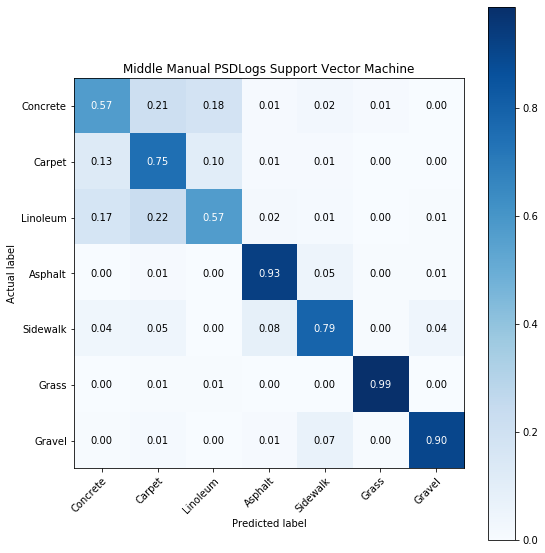

In [91]:
plot_confusion_matrix(test_test, predict_test, terrains, normalize=True, 
                      title='Middle Manual PSDLogs Support Vector Machine')